# Cell types homework

Summer Workshop on the Dynamic Brain
(Aug. 24, 2015)

## Imports & setup

In [12]:
import numpy as np # By convention we import it as "np"

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.style.use('ggplot')


## Exercises

### 1. Load  the  NWB  file  for  the  cell  with  specimen  ID  =  324493977

In [14]:
from allensdk.core.cell_types_cache import CellTypesCache

# !! update this path so that it points to your external hard drive !!
ctc = CellTypesCache(manifest_file='/media/swdb2015/Brain2015/cell_types/manifest.json')

# this saves the NWB file to 'specimen_324493977/ephys.nwb'
data_set = ctc.get_ephys_data(324493977)

### 2. Plot  both  the  current  traces  and  voltage  responses  for  sweeps  representing  three different  stimulus  protocols  (ramp,  short  square,  long  square)

In [85]:
# Choose sweeps by looking at online database. 
# Ramp sweep = 4, short square = 16, long square = 42

sweep_number = [4, 16, 42]
sweep_data = []
i = []
v = []





0 4
1 16
2 42


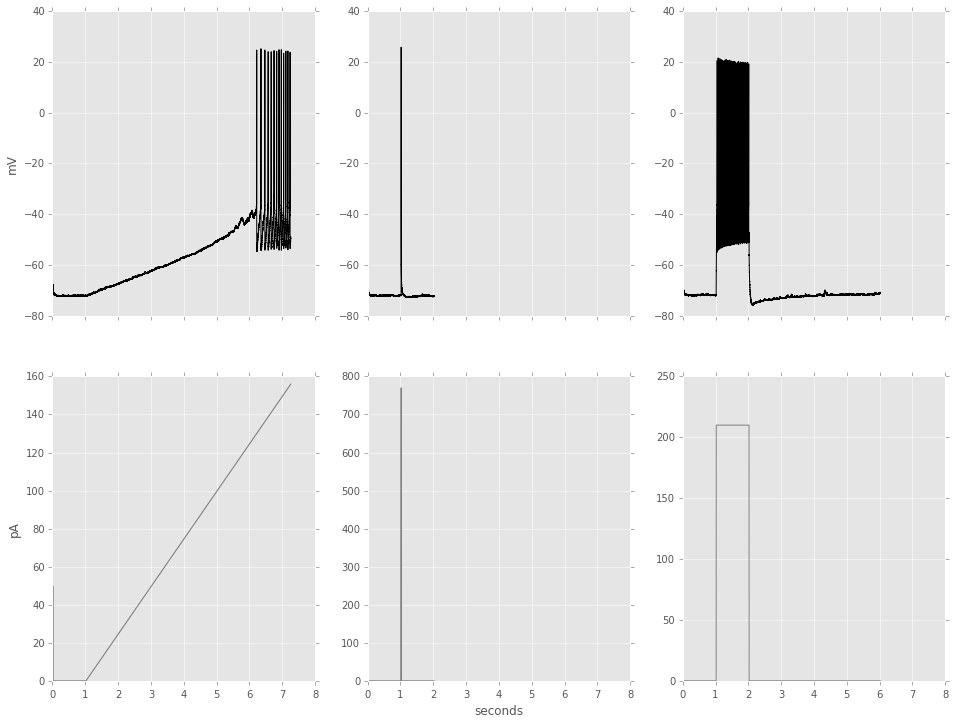

In [102]:
fig, axes = plt.subplots(2, 3, sharex=True, figsize=(16,12))

for listposition, sweep in enumerate(sweep_number):
    sweep_data = data_set.get_sweep(sweep) # Use list because its can grow, array can't
    i = sweep_data["stimulus"] # in A
    v = sweep_data["response"] # in V
    i *= 1e12 # convert to pA
    v *= 1e3 # convert to mV
    
    sampling_rate = sweep_data["sampling_rate"] # in Hz
    t = np.arange(0, len(v)) * (1.0 / sampling_rate)
    
    print listposition, sweep
    axes[0,listposition].plot(t, v, color='black')
    axes[1,listposition].plot(t, i, color='gray')
    axes[0,0].set_ylabel("mV")
    axes[1,0].set_ylabel("pA")
    axes[1,1].set_xlabel("seconds")

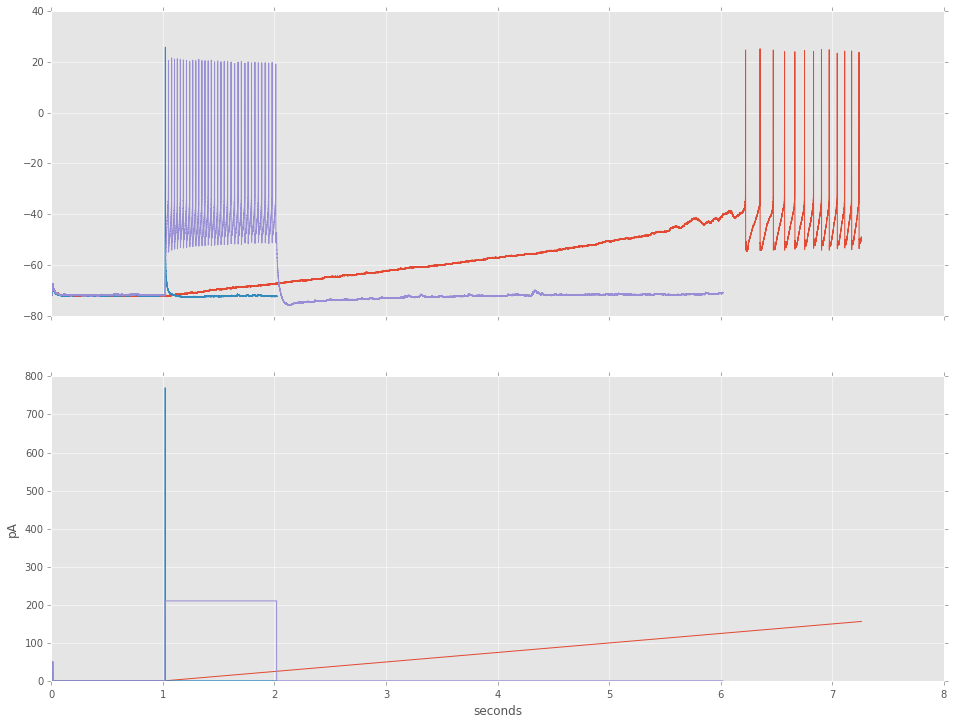

In [104]:
def get_sweep_v_i_t_from_set(data_set, sweep_number):
    sweep_data = data_set.get_sweep(sweep_number)
    i = sweep_data["stimulus"] # in A
    v = sweep_data["response"] # in V
    i *= 1e12 # convert to pA
    v *= 1e3 # convert to mV
    sampling_rate = sweep_data["sampling_rate"] # in Hz
    t = np.arange(0, len(v)) * (1.0 / sampling_rate)
    return v, i, t

sweep_numbers = sweep_number
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(16,12))

for s in sweep_numbers:
    v, i, t = get_sweep_v_i_t_from_set(data_set, s)
    axes[0].plot(t, v)
    axes[1].plot(t, i)

axes[1].set_ylabel("pA")
axes[1].set_xlabel("seconds")

### 4. Plot  a  cell’s  morphology  from  its  SWC  file  (it  can  be  the  same  cell  listed  above,  or  another  of  your  choosing).

In [105]:
# Quick look at the cell's morphology

from allensdk.core.cell_types_cache import CellTypesCache

ctc = CellTypesCache()

cells = ctc.get_cells(require_reconstruction=True)
print "Cells with reconstructions: ", len(cells)

# download and open the SWC file, if you haven't already
cell_id = 324493977
morphology = ctc.get_reconstruction(cell_id) 

Cells with reconstructions:  73


In [106]:
morphology = ctc.get_reconstruction(cell_id)
print morphology
compartment_list = morphology.compartment_list
print compartment_list[0]

{'parent': '-1', 'children': ['2080', '2', '2974', '2814', '2660', '2785', '1630'], 'radius': 6.3371, 'y': 327.708, 'x': 447.4287, 'z': 31.6865, 'type': 1, 'id': '1'}


Note that the `type` field refers to the type of neuronal compartment. The values can be `1` for the soma, `2` for the axon, `3` for dendrites, and `4` for apical dendrites (if present).

We can use this data to draw lines between each node and all its children to get a drawing of the cell. We'll do it looking at it from the front and from the side.

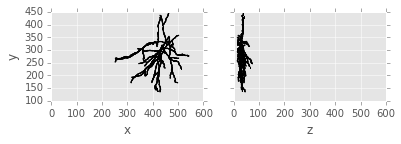

In [107]:
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True)
axes[0].set_aspect('equal', 'box-forced')
axes[1].set_aspect('equal', 'box-forced')

# Make a line drawing of x-y and y-z views
for n in morphology.compartment_list:
    child_nodes = [c for c in morphology.compartment_list if c['id'] in n['children']] 
    for c in child_nodes:
        axes[0].plot([n['x'], c['x']], [n['y'], c['y']], color='black')
        axes[1].plot([n['z'], c['z']], [n['y'], c['y']], color='black')

axes[0].set_ylabel('y')
axes[0].set_xlabel('x')
axes[1].set_xlabel('z')

### 3. Access  the  electrophysiology  features  of  all  cells  via  the  API.  Plot  the  upstroke/downstroke ratio  vs  Cre-­line.  Then  plot  it  versus  layer.  Re-plot  it  by  layer,  but  this  time  color  the  points  by  dendrite  type  (spiny  vs  aspiny). **Bonus plotting problem. Save this for later.

In [18]:
from allensdk.ephys.feature_extractor import EphysFeatureExtractor

sweep_number = 35

v, i, t = get_sweep_v_i_t_from_set(data_set, sweep_number) # from function created above

fx = EphysFeatureExtractor()

stim_start = 1.0
stim_duration = 1.0

fx.process_instance("", v, i, t, stim_start, stim_duration, "") # limits calculation to the duration of the stimulus
feature_data = fx.feature_list[0].mean # averages over all the spikes in a sweep as well as across different spikes
print "Avg spike width: {:.2f} ms".format(feature_data['width']) 
print "Avg spike threshold: {:.1f} mV".format(feature_data["threshold"])

Avg spike width: 0.93 ms
Avg spike threshold: -35.6 mV


We can take a look at all the properties calculated for a given spike.

In [19]:
import pprint
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(feature_data["spikes"][0])

{ 'downstroke': -114.58815026546496,
  'downstroke_i': 210.0,
  'downstroke_idx': 205802,
  'downstroke_t': 1.02901,
  'downstroke_v': -7.9375001774169549,
  'f_fast_ahp': -55.500001240521698,
  'f_fast_ahp_i': 210.0,
  'f_fast_ahp_t': 1.0306000000000002,
  'f_fast_ahp_v': -55.500001240521698,
  'f_peak': 18.156250405823823,
  'f_peak_i': 210.0,
  'f_peak_t': 1.02868,
  'f_slow_ahp': -49.812501113396166,
  'f_slow_ahp_t': 1.0336800000000002,
  'f_slow_ahp_time': 0.40799673602611697,
  'f_trough': -55.500001240521698,
  'half_height_width': 0.00059500000000012321,
  'peak_idx': 205736,
  'rise_time': 0.00055999999999989392,
  't': 1.0281100000000001,
  't_idx': 205622,
  't_idx_n30': 205666,
  't_n30': 1.0283300000000002,
  'thresh_ramp': 60.584564019317646,
  'threshold': -40.781250911531991,
  'threshold_i': 210.0,
  'threshold_idx': 205622,
  'threshold_t': 1.0281100000000001,
  'threshold_v': -40.781250911531991,
  'trough_i': 210.0,
  'trough_idx': 206120,
  'trough_t': 1.030600000

A list comprehension is an easy way to pull out the spike times. 

In [20]:
spike_times = [s["t"] for s in feature_data["spikes"]]

print spike_times[:5] 

[1.0281100000000001, 1.0409350000000002, 1.0536750000000001, 1.0686450000000001, 1.082835]


(0.9, 1.2)

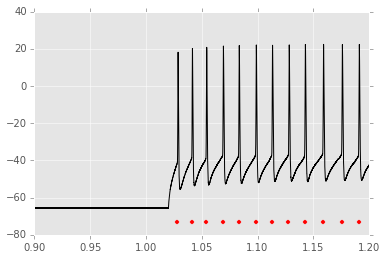

In [21]:
plt.figure()
plt.plot(t, v, color='black')

min_v = v.min()

min_v -= 5.0

plt.scatter(spike_times, np.ones(len(spike_times)) * min_v, c='r')
plt.xlim(0.9, 1.2)

### 5. Choose  a  GLIF  model  for  the  cell  above,  run  one  of  the  stimuli  you  plotted  in  #2,  and  plot  the  model’s  response.  

In [111]:
from allensdk.api.queries.glif_api import GlifApi
from allensdk.model.glif.glif_neuron import GlifNeuron
import allensdk.core.json_utilities as json_utilities

glif_model_id =  472304626 # Level 5 GLIF, ID of model for that particular cell
glif_api = GlifApi()

glif_api.get_neuronal_model(glif_model_id)
neuron_config = glif_api.get_neuron_config()
neuron = GlifNeuron.from_dict(neuron_config)

http://api.brain-map.org/api/v2/well_known_file_download/475436861


In [125]:


sweep_number = 42 # data for stimulus in model, aka current injection, simulated sweep
sweep_data = data_set.get_sweep(sweep_number)
i = sweep_data["stimulus"]
sampling_rate = sweep_data["sampling_rate"]
neuron.dt = 1.0 / sampling_rate
index_range = sweep_data["index_range"]

output = neuron.run(i[index_range[0]:index_range[1]])

We can take a look at the different outputs from the model.

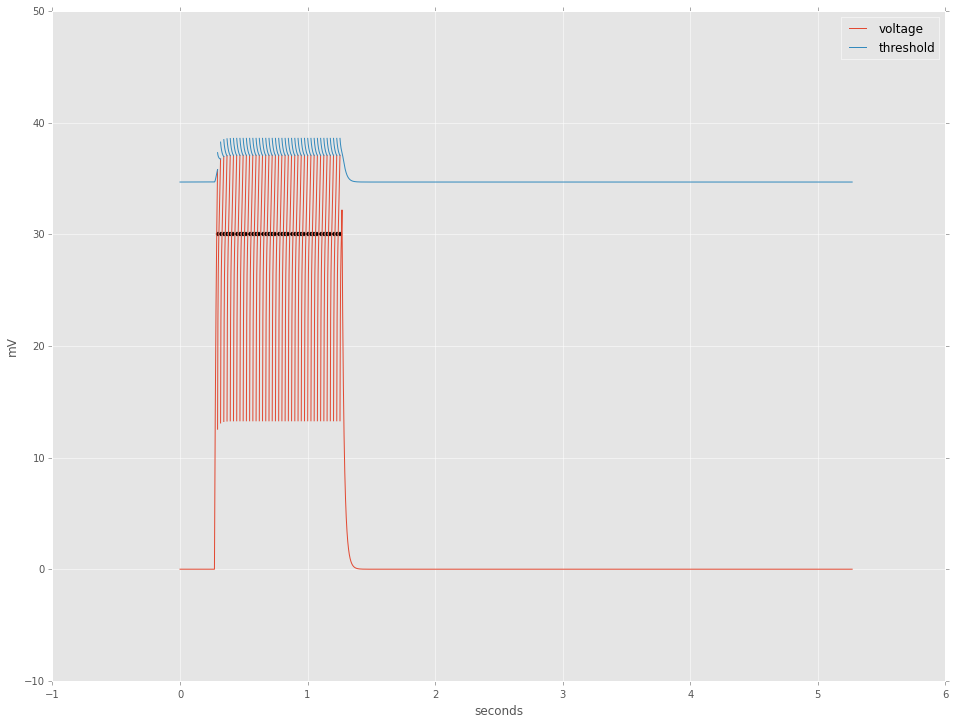

In [126]:
t = np.arange(0, len(output['voltage'])) * neuron.dt

plt.figure(figsize=(16,12))
plt.plot(t, output['voltage'] * 1e3, label='voltage')
plt.plot(t, output['threshold'] * 1e3, label='threshold')
plt.legend()

spike_times = output['interpolated_spike_times']
plt.scatter(spike_times, np.ones(len(spike_times)) * 30.0, c='k')

plt.ylabel("mV")
plt.xlabel("seconds")

### 6. Using  the  virtual  machine  that  contains  NEURON  (or  your  own  if  NEURON  is  installed  and  configured  appropriately),  download  and  run  the  biophysical  model  for  the  neuron  in  #1.  Run  the  same  stimulus  as  in  #5  and  plot  the  results..

In [122]:
from allensdk.api.queries.biophysical_perisomatic_api import BiophysicalPerisomaticApi

bp_api = BiophysicalPerisomaticApi()
bp_api.cache_stimulus = False # don't download the stimulus waveforms (NWB file)
neuronal_model_id = 472304676
bp_api.cache_data(neuronal_model_id, working_directory='neuronal_model')

We need to compile the .mod files that describe the biophysical mechanisms before using the model.

In [123]:
import os
os.chdir('neuronal_model')
!nrnivmodl modfiles

Creating x86_64 directory for .o files.

/home/swdb2015/SWDB-2015/presentations/celltypes/neuronal_model/neuronal_model
modfiles/CaDynamics.mod modfiles/Ca_HVA.mod modfiles/Ca_LVA.mod modfiles/Ih.mod modfiles/Im.mod modfiles/Im_v2.mod modfiles/K_P.mod modfiles/K_T.mod modfiles/Kd.mod modfiles/Kv2like.mod modfiles/Kv3_1.mod modfiles/NaTa.mod modfiles/NaTs.mod modfiles/NaV.mod modfiles/Nap.mod modfiles/SK.mod
CaDynamics.mod Ca_HVA.mod Ca_LVA.mod Ih.mod Im.mod Im_v2.mod K_P.mod K_T.mod Kd.mod Kv2like.mod Kv3_1.mod NaTa.mod NaTs.mod NaV.mod Nap.mod SK.mod
"/home/swdb2015/neuron/nrn/x86_64/bin/nocmodl" CaDynamics
Translating CaDynamics.mod into CaDynamics.c
Thread Safe
"/home/swdb2015/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/swdb2015/neuron/nrn/include/nrn" -I"/home/swdb2015/neuron/nrn/x86_64/lib"      -g -O2 -c -o CaDynamics.lo CaDynamics.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/swdb2015/neuron/nrn/include/nrn -I/home

Welcome back. Let's see what else is in the folder.

In [124]:
!ls # use ! to run a shell command from python notebooks -- e.g. to show folder contents

324493975.nwb	    Sst-IRES-Cre_Ai14_IVSCC_-173196.03.01.01_397206096_m.swc
472304676_fit.json  work
manifest.json	    x86_64
modfiles


Now that we have our files sorted, we'll configure the model.

In [127]:
from allensdk.model.biophys_sim.config import Config
from allensdk.model.biophysical_perisomatic.utils import Utils

description = Config().load("manifest.json")
utils = Utils(description) # object for setting up the model

manifest = description.manifest
morphology_path = manifest.get_path("MORPHOLOGY")
utils.generate_morphology(morphology_path)
utils.load_cell_parameters()

# Now let's set up the stimulus
h = utils.h # get access to the NEURON environment through "h"
stim = h.IClamp(h.soma[0](0.5)) # insert a current clamp stimulus in the middle of the soma
stim.amp = 0.2 # nA
stim.dur = 1000 # ms
stim.delay = 1000 # ms

# set up variable time step for faster execution
h.cvode_active(1)
h.cvode.atolscale("cai", 1e-4)
h.cvode.maxstep(10)

vec = utils.record_values() # save the voltage and time values

h.tstop = 3000 # run it for 3 sec

Now let's run the model and see what we get.

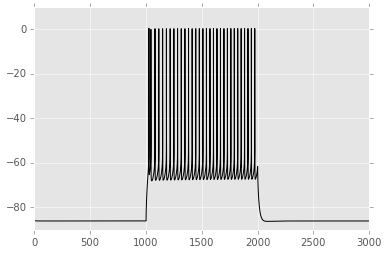

In [128]:
h.finitialize()
h.run()

plt.figure()
plt.plot(vec["t"], vec["v"], color='black')

We had to go down into the `neuronal_model` directory to compile and run the biophysical model, but let's go back up for the next part.

In [129]:
os.chdir("..") # ".." refers to the parent directory on a UNIX-like system

### 7. Extract  spike  train  features  from  the  original  data  for  the  cell  in  #1.  Plot  the  AP  height versus  the  time  of  the  spike.  *Left off here, resume later?

In [130]:
from allensdk.ephys.feature_extractor import EphysFeatureExtractor

sweep_number = 42

v, i, t = get_sweep_v_i_t_from_set(data_set, sweep_number) # from function created above

fx = EphysFeatureExtractor()

stim_start = 1.0
stim_duration = 1.0

fx.process_instance("", v, i, t, stim_start, stim_duration, "") # limits calculation to the duration of the stimulus
feature_data = fx.feature_list[0].mean # averages over all the spikes in a sweep as well as across different spikes
print "Avg spike width: {:.2f} ms".format(feature_data['width']) 
print "Avg spike threshold: {:.1f} mV".format(feature_data["threshold"])

Avg spike width: 0.45 ms
Avg spike threshold: -31.9 mV


In [ ]:
import pprint
pp = pprint.PrettyPrinter(indent=2)
pp.pprint(feature_data["spikes"][0])

In [ ]:
spike_times = [s["t"] for s in feature_data["spikes"]]

print spike_times[:5] 

## Pre-computed features in the database

There is also a set of features in the database that have already been computed, which could serve as good starting points for further analysis. We can query the database using the SDK to get these features.

In [25]:
from allensdk.core.cell_types_cache import CellTypesCache

ctc = CellTypesCache()
specimen_id = 464212183

# download all features for all cells
features = ctc.get_ephys_features()

# filter down to a specific cell
cell_features = [f for f in features if f['specimen_id'] == specimen_id]
print cell_features

[{u'tau': 19.0359532881798, u'threshold_t_long_square': 0.220845, u'thumbnail_sweep_id': 464306887, u'threshold_v_short_square': -40.7604179382324, u'threshold_v_ramp': -39.3958346048991, u'peak_v_short_square': 16.0000006357829, u'avg_isi': 50.9122222222222, u'sag': 0.200237980367221, u'blowout_voltage': -1.0164100676775, u'trough_t_ramp': 2.85047, u'threshold_t_ramp': 2.84760166666667, u'slow_trough_v_ramp': -54.4687525431315, u'adaptation': 0.0106601916957408, u'has_pause': False, u'electrode_0_pa': -73.0906168922019, u'trough_v_long_square': -58.59375, u'input_resistance_mohm': 129.36264, u'id': 464366365, u'latency': 30.7799999999998, u'fast_trough_v_ramp': -56.6354192097982, u'vm_for_sag': -90.46875, u'slow_trough_v_long_square': -56.6875, u'rheobase_sweep_id': 464306919, u'peak_t_ramp': 2.84821, u'threshold_t_short_square': 0.00310749999999993, u'has_burst': False, u'upstroke_downstroke_ratio_short_square': 1.82117838780572, u'slow_trough_t_long_square': 0.22639, u'threshold_v_l

That's how to get all the ephys features for a given specimen - what if we want a particular feature for all cells?

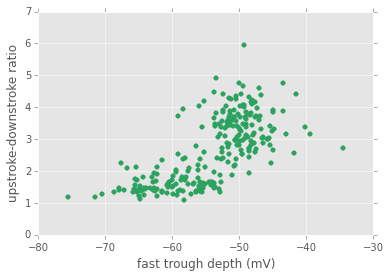

In [26]:
updown = np.array([f['upstroke_downstroke_ratio_short_square'] for f in features], dtype=float)
fasttrough = np.array([f['fast_trough_v_long_square'] for f in features], dtype=float)

plt.figure()
plt.scatter(fasttrough, updown, color='#2ca25f')
plt.ylabel("upstroke-downstroke ratio")
plt.xlabel("fast trough depth (mV)")

Let's use numpy to fit a regression line to these data and plot it.

First 5 rows of A:
[[-51.40625      1.        ]
 [-64.28125763   1.        ]
 [-59.09375      1.        ]
 [-44.96875      1.        ]
 [-51.59375      1.        ]]
m 0.107924372039 c 8.48403250554


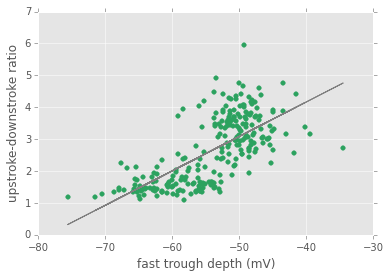

In [27]:
A = np.vstack([fasttrough, np.ones_like(updown)]).T # need to provide arguments to this function in a particular way
print "First 5 rows of A:"
print A[:5, :]

m, c = np.linalg.lstsq(A, updown)[0] 
print "m", m, "c", c

plt.figure()
plt.scatter(fasttrough, updown, color='#2ca25f')
plt.plot(fasttrough, m * fasttrough + c, c='gray')
plt.ylabel("upstroke-downstroke ratio")
plt.xlabel("fast trough depth (mV)")

It looks like there may be roughly two clusters in the data above. Maybe they relate to whether the cells are presumably excitatory (spiny) cells or inhibitory (aspiny) cells. Let's query the data to split up the two sets to see.

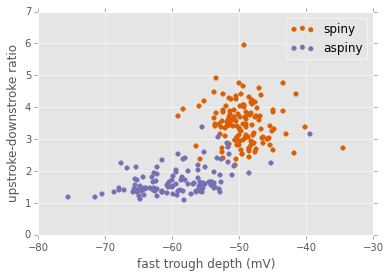

In [28]:
cells = ctc.get_cells()

cell_index = { c['id']: c for c in cells}

dendrite_types = ['spiny', 'aspiny']
data = {}

for dendrite_type in dendrite_types:
    type_features = [f for f in features if cell_index[f['specimen_id']]['dendrite_type'] == dendrite_type]
    data[dendrite_type] = {
        "fasttrough": [f['fast_trough_v_long_square'] for f in type_features], # creates dictionary with key=fasttrough and value as a list of all fasttrough data for that cell
        "updown": [f['upstroke_downstroke_ratio_short_square'] for f in type_features],
    }
    
plt.figure()
for a_type, color in zip(dendrite_types, ["#d95f02", "#7570b3"]): #zip integrates through two lists at the same time
    plt.scatter(data[a_type]['fasttrough'], data[a_type]['updown'], color=color, label=a_type)
plt.legend(loc='best')
plt.ylabel("upstroke-downstroke ratio")
plt.xlabel("fast trough depth (mV)")